In [ ]:
# !pip install pytorch-transformers
# !pip install transformers
# !pip install nltk


In [ ]:
import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
# !pip install tweet-preprocessor

In [ ]:
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import preprocessor as p

from transformers import XLMModel, BertTokenizer, BertForSequenceClassification, RobertaTokenizerFast, RobertaForSequenceClassification
from transformers import AdamW
import nltk
from nltk.stem import 	WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

from tqdm import tqdm, trange
import pandas as pd
import io
import numpy as np
import matplotlib.pyplot as plt
# % matplotlib inline


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()
torch.cuda.get_device_name(0)


'Tesla T4'

In [ ]:
MAX_LEN = 128

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/covid_fake_news-main/data/Constraint_Train.csv")
val_df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/covid_fake_news-main/data/Constraint_Val.csv")
test_df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/covid_fake_news-main/data/Constraint_Test.csv")


In [ ]:
wordnet_lemmatizer = WordNetLemmatizer()
porter_stemmer  = PorterStemmer()


In [ ]:
p.set_options(p.OPT.URL, p.OPT.EMOJI)

def preprocess(row, lemmatizer, stemmer):
    text = row['tweet']
    # text = text.strip('\xa0')
    text = p.clean(text)
    tokenization = nltk.word_tokenize(text)     
    tokenization = [w for w in tokenization if not w in stop_words]
    #   text = ' '.join([porter_stemmer.stem(w) for w in tokenization])
    #   text = ' '.join([lemmatizer.lemmatize(w) for w in tokenization])
    # text = re.sub(r'\([0-9]+\)', '', text).strip()    
    return text


In [ ]:
df['tweet'] = df.apply(lambda x: preprocess(x, wordnet_lemmatizer, porter_stemmer), 1)
val_df['tweet'] = val_df.apply(lambda x: preprocess(x, wordnet_lemmatizer, porter_stemmer), 1)
test_df['tweet'] = test_df.apply(lambda x: preprocess(x, wordnet_lemmatizer, porter_stemmer), 1)


In [ ]:
def map_label(row):
    return 0 if row['label']=='real' else 1

df['label_encoded'] = df.apply(lambda x: map_label(x), 1)
val_df['label_encoded'] = val_df.apply(lambda x: map_label(x), 1)
# test_df['label_encoded'] = test_df.apply(lambda x: map_label(x), 1)


In [ ]:
train_sentences = df.tweet.values
val_sentences = val_df.tweet.values
test_sentences = test_df.tweet.values

train_labels = df.label_encoded.values
val_labels = val_df.label_encoded.values


In [ ]:
df

,id,tweet,label,label_encoded
0,1,The CDC currently reports 99031 deaths. In gen...,real,0
1,2,States reported 1121 deaths a small rise from ...,real,0
2,3,Politically Correct Woman (Almost) Uses Pandem...,fake,1
3,4,#IndiaFightsCorona: We have 1524 #COVID testin...,real,0
4,5,Populous states can generate large case counts...,real,0
...,...,...,...,...
6415,6416,A tiger tested positive for COVID-19 please st...,fake,1
6416,6417,???Autopsies prove that COVID-19 is?? a blood ...,fake,1
6417,6418,_A post claims a COVID-19 vaccine has already ...,fake,1
6418,6419,Aamir Khan Donate 250 Cr. In PM Relief Cares Fund,fake,1


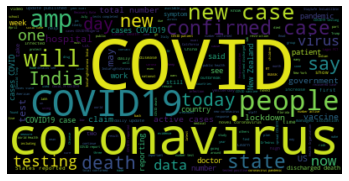

In [ ]:
# Re-Modelling (not BERT)
from wordcloud import WordCloud

wc = WordCloud(background_color = "black")
wc.generate(' '.join(df['tweet']))
plt.imshow(wc, interpolation = "bilinear")
plt.axis('off')
plt.show()

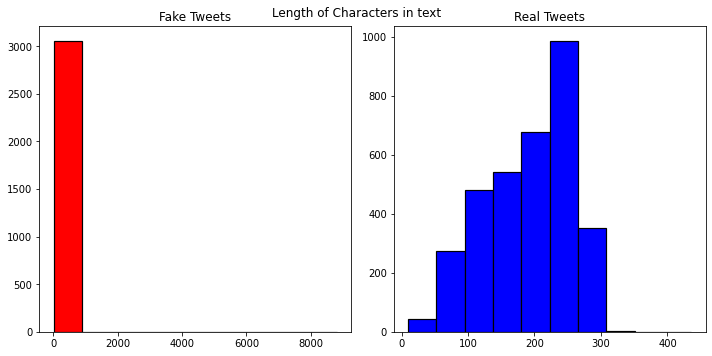

In [ ]:
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(10,5))
char_len_dis = df[df['label_encoded']==1]['tweet'].str.len()
ax1.hist(char_len_dis,color='red',edgecolor='black', linewidth=1.2)
ax1.set_title('Fake Tweets')
char_len_ndis = df[df['label_encoded']==0]['tweet'].str.len()
ax2.hist(char_len_ndis,color='blue',edgecolor='black', linewidth=1.2)
ax2.set_title('Real Tweets')
plt.suptitle("Length of Characters in text")
plt.tight_layout()
plt.show()


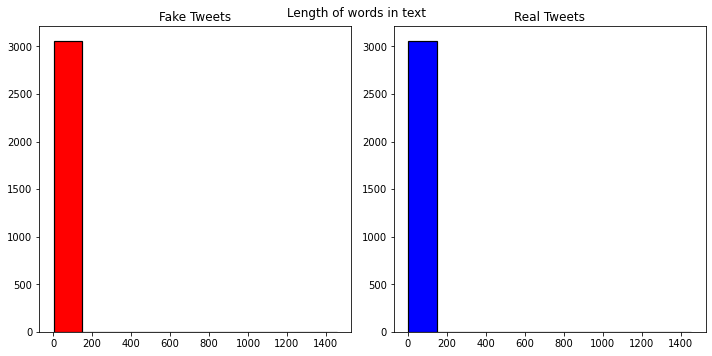

In [ ]:
# Analysing number of words in text.

fig,(ax1,ax2) = plt.subplots(1,2,figsize=(10,5))
char_len_dis = df[df['label_encoded']==1]['tweet'].str.split().map(lambda x: len(x))
ax1.hist(char_len_dis,color='red',edgecolor='black', linewidth=1.2)
ax1.set_title('Fake Tweets')
char_len_ndis = df[df['label_encoded']==1]['tweet'].str.split().map(lambda x: len(x))
ax2.hist(char_len_ndis,color='blue',edgecolor='black', linewidth=1.2)
ax2.set_title('Real Tweets')
plt.suptitle("Length of words in text")
plt.tight_layout()
plt.show()

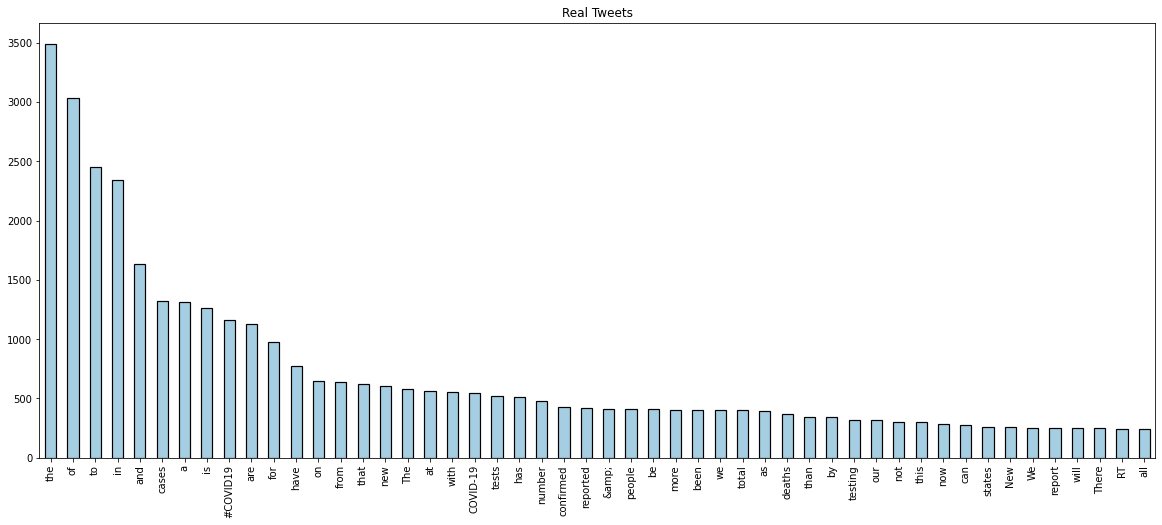

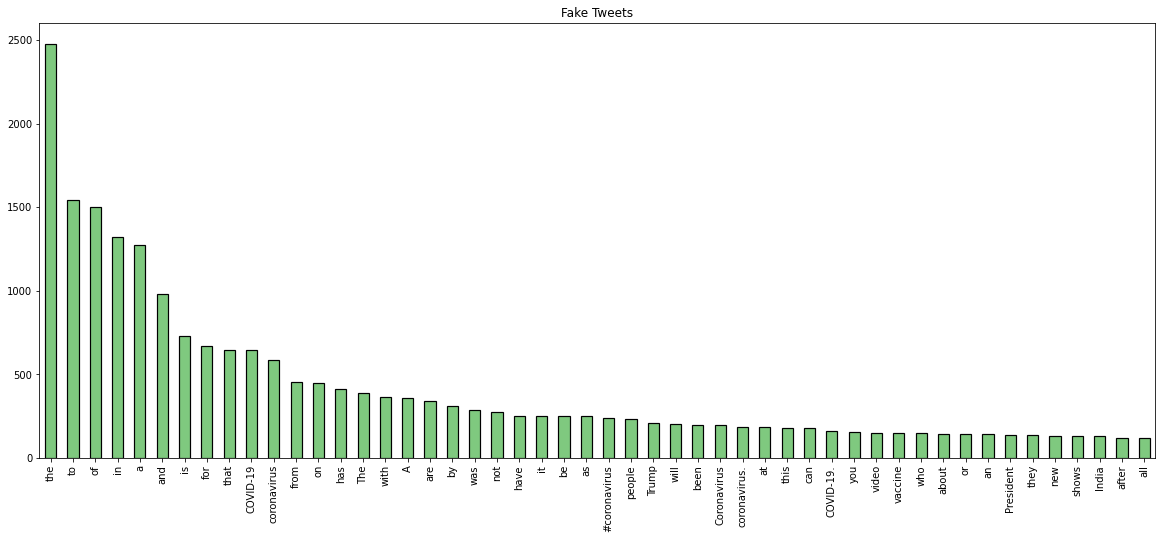

In [ ]:
real_tweet = df[df.label_encoded == 0]["tweet"]
fake_tweet = df[df.label_encoded == 1]["tweet"]

color = ['Paired','Accent']
splitedData = [real_tweet,fake_tweet]
title = ["Real Tweets", "Fake Tweets"]
for item in range(2):
    plt.figure(figsize=(20,8))
    plt.title(title[item],fontsize=12)
    pd.Series(' '.join([i for i in splitedData[item]]).split()).value_counts().head(50).plot(kind='bar',fontsize=10,colormap=color[item],edgecolor='black', linewidth=1.2)
    plt.show()

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

def top_ngrams(data,n,grams):
    '''
    Input:- Data: Input Data
            n   : Number of top n-words
            grams:Type of N-grams. 1-> Unigram  2-> Bigram  3->Trigram
            
    Output: Word Frequency of top  n words
    
    '''
    if grams == 1:
        count_vec = CountVectorizer(ngram_range=(1,1)).fit(data)
        bow = count_vec.transform(data)
        add_words = bow.sum(axis=0)
        word_freq = [(word, add_words[0, idx]) for word, idx in count_vec.vocabulary_.items()]
        word_freq = sorted(word_freq, key = lambda x: x[1], reverse=True)
    elif grams == 2:
        count_vec = CountVectorizer(ngram_range=(2,2)).fit(data)
        bow = count_vec.transform(data)
        add_words = bow.sum(axis=0)
        word_freq = [(word,add_words[0,idx]) for word,idx in count_vec.vocabulary_.items()]
        word_freq = sorted(word_freq, key = lambda x: x[1], reverse=True)
    elif grams == 3:
        count_vec = CountVectorizer(ngram_range=(3,3)).fit(data)
        bow = count_vec.transform(data)
        add_words = bow.sum(axis=0)
        word_freq = [(word,add_words[0,idx]) for word,idx in count_vec.vocabulary_.items()]
        word_freq = sorted(word_freq, key = lambda x: x[1], reverse=True)

    return word_freq[:n]

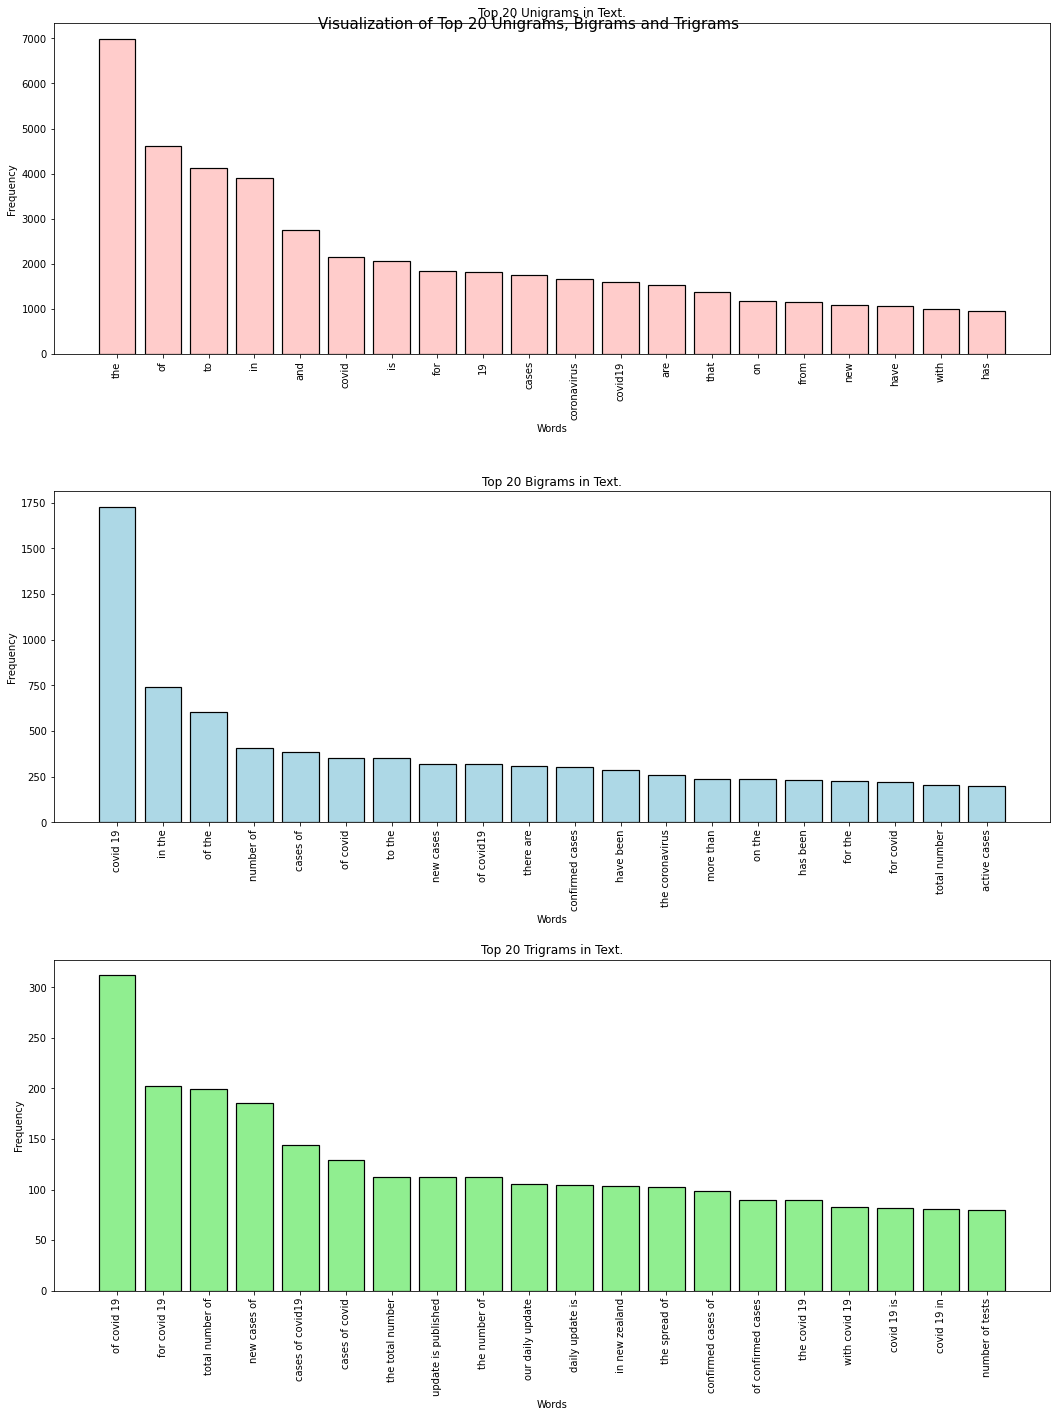

In [ ]:
common_words_uni = top_ngrams(df.tweet,20,1)
common_words_bi = top_ngrams(df.tweet,20,2)
common_words_tri = top_ngrams(df.tweet,20,3)
common_words_uni_df = pd.DataFrame(common_words_uni,columns=['word','freq'])
common_words_bi_df = pd.DataFrame(common_words_bi,columns=['word','freq'])
common_words_tri_df = pd.DataFrame(common_words_tri,columns=['word','freq'])
fig,(ax1,ax2,ax3) = plt.subplots(3,1,figsize=(15,20))
ax1.bar(common_words_uni_df["word"],common_words_uni_df["freq"],color="#FFCCCB",edgecolor='black', linewidth=1.2)
ax1.set_title("Top 20 Unigrams in Text.")
ax1.set_xlabel("Words")
ax1.set_ylabel("Frequency")
ax1.set_xticklabels(rotation=90,labels=common_words_uni_df["word"],fontsize=10)    

ax2.bar(common_words_bi_df["word"],common_words_bi_df["freq"],color="lightblue",edgecolor='black', linewidth=1.2)
ax2.set_title("Top 20 Bigrams in Text.")
ax2.set_xlabel("Words")
ax2.set_ylabel("Frequency")
ax2.set_xticklabels(rotation=90,labels=common_words_bi_df["word"],fontsize=10)    

ax3.bar(common_words_tri_df["word"],common_words_tri_df["freq"] ,color="lightgreen",edgecolor='black', linewidth=1.2)
ax3.set_title("Top 20 Trigrams in Text.")
ax3.set_xlabel("Words")
ax3.set_ylabel("Frequency")
ax3.set_xticklabels(rotation=90,labels=common_words_tri_df["word"],fontsize=10) 
plt.suptitle("Visualization of Top 20 Unigrams, Bigrams and Trigrams",fontsize="15")
plt.tight_layout(pad=1.85)
plt.show()

In [ ]:
# Creating functions for using BOW,TF-IDF 

def encoding(train_data,test_data,bow,tf_idf):
    '''
    Input : Data to be encoded and choice of encoding.
    Output : Desired Encoding.
    
    '''
    if bow==True: 
        cv = CountVectorizer(ngram_range=(1, 1))
        cv_df_train = cv.fit_transform(train_data).toarray()
        train_df = pd.DataFrame(cv_df_train,columns=cv.get_feature_names())
        cv_df_test = cv.transform(test_data).toarray()
        test_df = pd.DataFrame(cv_df_test,columns=cv.get_feature_names())
        
    elif tf_idf==True:
        
        tfidf = TfidfVectorizer(
            ngram_range=(1, 1), use_idf=1,smooth_idf=1,sublinear_tf=1)    
        tf_df_train = tfidf.fit_transform(train_data).toarray()
        train_df = pd.DataFrame(tf_df_train,columns=tfidf.get_feature_names())
        tf_df_test = tfidf.transform(test_data).toarray()
        test_df = pd.DataFrame(tf_df_test,columns=tfidf.get_feature_names())
        
    return train_df,test_df


df_final,test_df_final = encoding(df.tweet,test_df.tweet,bow=True,tf_idf=False)
label_final = np.array(df.label_encoded) # Converting y to array

In [ ]:
df_final.shape,label_final.shape,test_df_final.shape

((6420, 14480), (6420,), (2140, 14480))

In [ ]:
# Converting to list
text = df.tweet.tolist()
text_test = test_df.tweet.tolist()
text[:3] # Analysing first 3 sentence in train data.

['The CDC currently reports 99031 deaths. In general the discrepancies in death counts between different sources are small and explicable. The death toll stands at roughly 100000 people today.',
 'States reported 1121 deaths a small rise from last Tuesday. Southern states reported 640 of those deaths.',
 'Politically Correct Woman (Almost) Uses Pandemic as Excuse Not to Reuse Plastic Bag #coronavirus #nashville']

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
token = Tokenizer()
token.fit_on_texts(text)

In [ ]:
encoded_text = token.texts_to_sequences(text)
encoded_text_test = token.texts_to_sequences(text_test)
encoded_text[:2]

In [ ]:
# Finding the vocab size
vocab_size = len(token.word_index)+1
print("The vocabulary size is : {}".format(vocab_size))

The vocabulary size is : 14822


In [ ]:
# Considering 120 words
max_length = 120 # Considering top 120 tokens.
X = pad_sequences(encoded_text,maxlen=max_length,padding='post') # This is done to make the sequence of same length.
X_test = pad_sequences(encoded_text_test,maxlen=max_length,padding='post')
X

array([[   1,  146,  302, ...,    0,    0,    0],
       [  37,   48, 7055, ...,    0,    0,    0],
       [5005, 1911,  480, ...,    0,    0,    0],
       ...,
       [   5,  303,  174, ...,    0,    0,    0],
       [2973, 1075, 2842, ...,    0,    0,    0],
       [  35,   21,   38, ...,    0,    0,    0]], dtype=int32)

In [ ]:
# Dividing the data into training, validation and testing
from sklearn.model_selection import train_test_split

#  for Word Embeddings
x_train, x_test, y_train, y_test = train_test_split(X, df.label_encoded, test_size=0.1, random_state=42)

In [ ]:
# Validation setting
X_train, X_valid, Y_train, Y_valid = train_test_split(x_train, y_train, test_size=0.1, random_state=42)

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report,accuracy_score

model_1 = LogisticRegression(C=1.0)
model_1.fit(x_train, y_train)
pred_1 = model_1.predict(x_test)
cr1 = classification_report(y_test,pred_1)
print(cr1)

              precision    recall  f1-score   support

           0       0.73      0.61      0.66       340
           1       0.63      0.74      0.68       302

    accuracy                           0.67       642
   macro avg       0.68      0.68      0.67       642
weighted avg       0.68      0.67      0.67       642



/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [ ]:
from sklearn.naive_bayes import MultinomialNB

model_2 = MultinomialNB(alpha=0.7)
model_2.fit(x_train,y_train)
pred_2 = model_2.predict(x_test)
cr2    = classification_report(y_test,pred_2)
print(cr2)

              precision    recall  f1-score   support

           0       0.74      0.65      0.69       340
           1       0.65      0.75      0.70       302

    accuracy                           0.69       642
   macro avg       0.70      0.70      0.69       642
weighted avg       0.70      0.69      0.69       642



In [ ]:
from sklearn.tree import DecisionTreeClassifier

model_3 = DecisionTreeClassifier()
model_3.fit(x_train,y_train)
pred_3 = model_3.predict(x_test)
cr3    = classification_report(y_test,pred_3)
print(cr3)

              precision    recall  f1-score   support

           0       0.78      0.76      0.77       340
           1       0.74      0.75      0.75       302

    accuracy                           0.76       642
   macro avg       0.76      0.76      0.76       642
weighted avg       0.76      0.76      0.76       642



In [ ]:
from sklearn.ensemble import RandomForestClassifier

model_4 = RandomForestClassifier()
model_4.fit(x_train,y_train)
pred_4 = model_4.predict(x_test)
cr4    = classification_report(y_test,pred_4)
print(cr4)


              precision    recall  f1-score   support

           0       0.77      0.83      0.80       340
           1       0.79      0.72      0.75       302

    accuracy                           0.78       642
   macro avg       0.78      0.78      0.78       642
weighted avg       0.78      0.78      0.78       642



In [ ]:
from xgboost import XGBClassifier

model_5 = XGBClassifier()
model_5.fit(x_train,y_train)
pred_5 = model_5.predict(x_test)
cr5    = classification_report(y_test,pred_5)
print(cr5)


              precision    recall  f1-score   support

           0       0.78      0.82      0.80       340
           1       0.79      0.74      0.76       302

    accuracy                           0.78       642
   macro avg       0.78      0.78      0.78       642
weighted avg       0.78      0.78      0.78       642



In [ ]:
# !pip install catboost
from catboost import CatBoostClassifier

model_6 = CatBoostClassifier(iterations=100)
model_6.fit(x_train,y_train)
pred_6 = model_6.predict(x_test)
cr6    = classification_report(y_test,pred_6)
print(cr6)


     |████████████████████████████████| 67.3MB 152kB/s 
Learning rate set to 0.179975
0:	learn: 0.6495383	total: 69.6ms	remaining: 6.89s
1:	learn: 0.6213385	total: 88.1ms	remaining: 4.32s
2:	learn: 0.5959227	total: 107ms	remaining: 3.44s
3:	learn: 0.5717489	total: 124ms	remaining: 2.99s
4:	learn: 0.5589007	total: 143ms	remaining: 2.71s
5:	learn: 0.5507016	total: 160ms	remaining: 2.51s
6:	learn: 0.5424903	total: 178ms	remaining: 2.36s
7:	learn: 0.5257956	total: 196ms	remaining: 2.25s
8:	learn: 0.5215407	total: 216ms	remaining: 2.19s
9:	learn: 0.5132173	total: 237ms	remaining: 2.13s
10:	learn: 0.5077903	total: 257ms	remaining: 2.08s
11:	learn: 0.5014234	total: 275ms	remaining: 2.01s
12:	learn: 0.4958761	total: 292ms	remaining: 1.96s
13:	learn: 0.4919426	total: 310ms	remaining: 1.9s
14:	learn: 0.4874925	total: 326ms	remaining: 1.85s
15:	learn: 0.4834896	total: 344ms	remaining: 1.81s
16:	learn: 0.4795329	total: 370ms	remaining: 1.8s
17:	learn: 0.4765674	total: 391ms	remaining: 1.78s
18:	le

In [ ]:
from sklearn.linear_model import PassiveAggressiveClassifier
model_7 = PassiveAggressiveClassifier()
model_7.fit(x_train,y_train)
pred_7 = model_7.predict(x_test)
cr7    = classification_report(y_test,pred_7)
print(cr7)

              precision    recall  f1-score   support

           0       0.69      0.49      0.57       340
           1       0.57      0.75      0.65       302

    accuracy                           0.62       642
   macro avg       0.63      0.62      0.61       642
weighted avg       0.63      0.62      0.61       642



In [ ]:
from sklearn.ensemble import VotingClassifier

estimators = []
estimators.append(('LR', 
                  LogisticRegression(C=1.0)))
estimators.append(('NB', MultinomialNB(alpha=0.7)))
estimators.append(('XBG', XGBClassifier()))


vc = VotingClassifier(estimators=estimators,voting='soft')
vc.fit(x_train,y_train)
pred_vc = vc.predict(x_test)
cr_vc    = classification_report(y_test,pred_vc)
print(cr_vc)


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


              precision    recall  f1-score   support

           0       0.74      0.65      0.69       340
           1       0.65      0.75      0.70       302

    accuracy                           0.69       642
   macro avg       0.70      0.70      0.69       642
weighted avg       0.70      0.69      0.69       642



In [ ]:
# LSTM
# glove_vectors matrix needed

from tensorflow.keras.layers import Embedding,Dropout
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.layers import LSTM,Bidirectional,GRU,MaxPooling1D,Conv1D
from tensorflow.keras.layers import Dense
from keras.optimizers import Adam,SGD
from tensorflow.keras import regularizers

embedding_feature_vector = 200 # Since we used glove vector embedding of dim 200.
model = Sequential()
model.add(Embedding(vocab_size,embedding_feature_vector,input_length=max_length,weights = [word_vector_matrix], trainable = False))
model.add(Dropout(0.35))
model.add(LSTM(200))
model.add(Dropout(0.35))
model.add(Dense(32,activation='relu'))
model.add(Dense(1,activation='sigmoid'))
model.compile(loss='binary_crossentropy',optimizer=Adam(lr=1e-4),metrics=['accuracy'])
print(model.summary())

In [ ]:
# LSTM 2

from tensorflow.keras.callbacks import *
n_epoch = 30

early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=1, 
                           mode='min', restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, 
                              verbose=1, mode='min')

history = model.fit(x_train,y_train,callbacks=[reduce_lr,early_stop],epochs=n_epoch,batch_size= 64)

predictions = model.predict_classes(x_test)
cr = classification_report(y_test,predictions)
print(cr)

In [ ]:
# Verifying the results.
from tensorflow.keras.models import model_from_json
model = model_from_json(model_82)
model.load_weights('./weights_82_81(82).h5')
model.compile(loss='binary_crossentropy',optimizer=Adam(lr=1e-4),metrics=['accuracy'])
print(model.summary())
model.evaluate(x_test, y_test, batch_size=64, verbose=2)



In [ ]:
# LSTM - glove_vectors

glove_vectors = dict()

# Now, we will convert the words in glove vectors into key value pairs. We have used glove representation of 200D. 


file = open('../input/glove6b200d/glove.6B.200d.txt',encoding='utf-8')

for line in file:
    values = line.split()  # contains list of keys and their vectors
    word = values[0] # contains words
    vectors = np.asarray(values[1:]) # storing vectors
    glove_vectors[word] = vectors #storing the vector representation of the respective word in the dictionary
file.close()

FileNotFoundError: ignored

In [ ]:
# BERT (DL)

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

In [ ]:
def Encode_TextWithAttention(sentence,tokenizer,maxlen,padding_type='max_length',attention_mask_flag=True):
    encoded_dict = tokenizer.encode_plus(sentence, add_special_tokens=True, max_length=maxlen, truncation=True, padding=padding_type, return_attention_mask=attention_mask_flag)
    return encoded_dict['input_ids'],encoded_dict['attention_mask']

def Encode_TextWithoutAttention(sentence,tokenizer,maxlen,padding_type='max_length',attention_mask_flag=False):
    encoded_dict = tokenizer.encode_plus(sentence, add_special_tokens=True, max_length=maxlen, truncation=True, padding=padding_type, return_attention_mask=attention_mask_flag)
    return encoded_dict['input_ids']

def get_TokenizedTextWithAttentionMask(sentenceList, tokenizer):
    token_ids_list,attention_mask_list = [],[]
    for sentence in sentenceList:
        token_ids,attention_mask = Encode_TextWithAttention(sentence,tokenizer,MAX_LEN)
        token_ids_list.append(token_ids)
        attention_mask_list.append(attention_mask)
    return token_ids_list,attention_mask_list

def get_TokenizedText(sentenceList, tokenizer):
    token_ids_list = []
    for sentence in sentenceList:
        token_ids = Encode_TextWithoutAttention(sentence,tokenizer,MAX_LEN)
        token_ids_list.append(token_ids)
    return token_ids_list

In [ ]:
train_token_ids,train_attention_masks = torch.tensor(get_TokenizedTextWithAttentionMask(train_sentences,tokenizer))
val_token_ids,val_attention_masks = torch.tensor(get_TokenizedTextWithAttentionMask(val_sentences,tokenizer))
test_token_ids,test_attention_masks = torch.tensor(get_TokenizedTextWithAttentionMask(test_sentences,tokenizer))

train_labels = torch.tensor(train_labels)
val_labels = torch.tensor(val_labels)

In [ ]:
batch_size = 32

train_data = TensorDataset(train_token_ids, train_attention_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

validation_data = TensorDataset(val_token_ids, val_attention_masks, val_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

test_data = TensorDataset(test_token_ids, test_attention_masks)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)


In [ ]:
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2).cuda()



Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [ ]:
param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]


In [ ]:
optimizer = AdamW(optimizer_grouped_parameters, lr=2e-5)

In [ ]:
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [ ]:
train_loss_set = []
best_val_accuracy = 0.90
directory_path = ''
epochs = 15

for _ in trange(epochs, desc="Epoch"):
    model.train()
    tr_loss = 0
    nb_tr_examples, nb_tr_steps = 0, 0
  
    for step, batch in enumerate(train_dataloader):
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        optimizer.zero_grad()
        outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
        loss = outputs[0]
        logits = outputs[1]
        train_loss_set.append(loss.item())    
        loss.backward()
        optimizer.step()

        tr_loss += loss.item()
        nb_tr_examples += b_input_ids.size(0)
        nb_tr_steps += 1

    print("Train loss: {}".format(tr_loss/nb_tr_steps))

    model.eval()

    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0

    for batch in validation_dataloader:
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        with torch.no_grad():
          output = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
          logits = output[0]

        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        tmp_eval_accuracy = flat_accuracy(logits, label_ids)

        eval_accuracy += tmp_eval_accuracy
        nb_eval_steps += 1

    print("Validation Accuracy: {}".format(eval_accuracy/nb_eval_steps))
    Validation_Accuracy = (eval_accuracy/nb_eval_steps)
 #   if(Validation_Accuracy >= best_val_accuracy):
 #       torch.save(model.state_dict(), directory_path+'models/BERT_base_uncased_best_model.ckpt')
 #       best_val_accuracy = Validation_Accuracy
 #       print('Model Saved')





Epoch:   0%|          | 0/15 [00:00<?, ?it/s]

Train loss: 0.08128099762301762



Epoch:   7%|▋         | 1/15 [02:42<37:51, 162.24s/it]

Validation Accuracy: 0.9636194029850746
Train loss: 0.044311681506339816



Epoch:  13%|█▎        | 2/15 [05:23<35:04, 161.91s/it]

Validation Accuracy: 0.9626865671641791
Train loss: 0.024134812596837866



Epoch:  20%|██        | 3/15 [08:04<32:21, 161.77s/it]

Validation Accuracy: 0.9692164179104478
Train loss: 0.012043957318473533



Epoch:  27%|██▋       | 4/15 [10:46<29:40, 161.83s/it]

Validation Accuracy: 0.9626865671641791
Train loss: 0.014723373334901176



Epoch:  33%|███▎      | 5/15 [13:28<26:57, 161.80s/it]

Validation Accuracy: 0.9626865671641791
Train loss: 0.017137485398477714



Epoch:  40%|████      | 6/15 [16:10<24:16, 161.79s/it]

Validation Accuracy: 0.96875
Train loss: 0.011814287265522905



Epoch:  47%|████▋     | 7/15 [18:52<21:34, 161.81s/it]

Validation Accuracy: 0.9673507462686567
Train loss: 0.003054098201080443



Epoch:  53%|█████▎    | 8/15 [21:33<18:52, 161.72s/it]

Validation Accuracy: 0.96875
Train loss: 0.004236682641406229



Epoch:  60%|██████    | 9/15 [24:14<16:09, 161.61s/it]

Validation Accuracy: 0.9696828358208955
Train loss: 0.002018785882719204



Epoch:  67%|██████▋   | 10/15 [26:56<13:27, 161.57s/it]

Validation Accuracy: 0.9734141791044776
Train loss: 0.0016913057729313428



Epoch:  73%|███████▎  | 11/15 [29:37<10:46, 161.54s/it]

Validation Accuracy: 0.9692164179104478
Train loss: 0.0012563640432460095



Epoch:  80%|████████  | 12/15 [32:19<08:04, 161.48s/it]

Validation Accuracy: 0.9696828358208955
Train loss: 0.0006422593170503011



Epoch:  87%|████████▋ | 13/15 [35:00<05:22, 161.43s/it]

Validation Accuracy: 0.9692164179104478
Train loss: 0.00012463681539983965



Epoch:  93%|█████████▎| 14/15 [37:42<02:41, 161.46s/it]

Validation Accuracy: 0.9701492537313433
Train loss: 9.283943106324773e-05



Epoch: 100%|██████████| 15/15 [40:23<00:00, 161.59s/it]

Validation Accuracy: 0.972481343283582


In [ ]:
# Accuracy Summary

acc_1 = accuracy_score(y_test, pred_1)
acc_2 = accuracy_score(y_test, pred_2)
acc_3 = accuracy_score(y_test, pred_3)
acc_4 = accuracy_score(y_test, pred_4)
acc_5 = accuracy_score(y_test, pred_5)
acc_6 = accuracy_score(y_test, pred_6)
acc_7 = accuracy_score(y_test, pred_7)
acc_vc = accuracy_score(y_test, pred_vc)
# LSTM; acc_9 = accuracy_score(y_test, pred_9)
results = pd.DataFrame([["Logistic Regression",acc_1],["Naive Bayes",acc_2],["Decision Trees",acc_3],
                       ["Random Forest",acc_4],["XGBoost",acc_5],["CatBoost",acc_6],
                       ["Passive Aggressor",acc_7],["Voting Ensemble(LR+NB+XGB)",acc_vc], ["BERT", Validation_Accuracy]],columns = ["Models","Accuracy Score"]).sort_values(by='Accuracy Score',ascending=False)
results.style.background_gradient(cmap='Blues')


,Models,Accuracy Score
8,BERT,0.972481
5,CatBoost,0.786604
4,XGBoost,0.783489
3,Random Forest,0.778816
2,Decision Trees,0.760125
1,Naive Bayes,0.693146
7,Voting Ensemble(LR+NB+XGB),0.693146
0,Logistic Regression,0.672897
6,Passive Aggressor,0.615265
